In [1]:
import numpy as np
import torch
import torch_geometric
import open3d as o3d
#utils
import h5py
import os
import dataclasses
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss
from sklearn.model_selection import train_test_split
from datetime import datetime

from torch_geometric.utils import to_dense_batch





Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


## Utils

In [2]:
from utils import model_size

### Load data

In [3]:
from utils.data import load_h5_data, PairData, PCDDataset
from torch_geometric.loader import DataLoader as PyGLoader

### Viz

In [4]:
from utils.viz import viz_many_mpl, viz_many

### Configs

In [5]:
from train.config import TrainConfig, ModelConfig, DataConfig
from omegaconf import OmegaConf

In [6]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")

d = OmegaConf.load(os.path.join("train", "config.yaml"))
model_config = d.model_config
train_config = d.train_config
data_config = d.data_config


In [7]:
print(model_config)
print(train_config)
print(data_config)

{'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 2, 'channels': 24, 'n_dgcn_blocks': 3, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True}
{'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}
{'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 5, 'use_randominput': True}


# Data

In [9]:
#Load dataset
dataset = PCDDataset.from_h5(data_path, num_point=data_config.num_point, up_ratio=model_config.r, skip_rate=data_config.skip_rate)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 13800 samples


In [10]:
# Check one sample
data = dataset[42]
data_cloud, gt_cloud = data.pos_s, data.pos_t

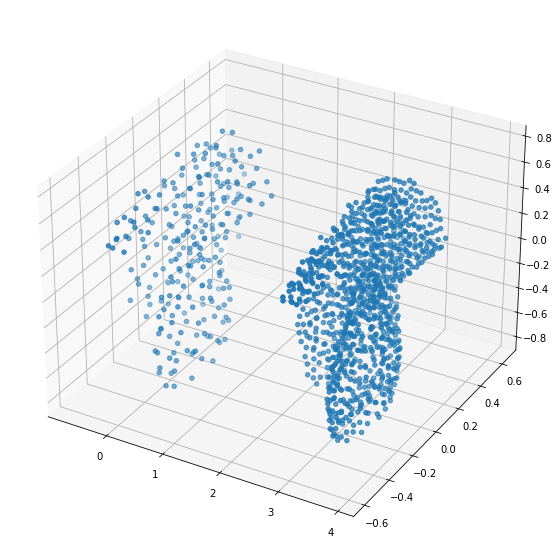

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([data_cloud, gt_cloud], ax = ax)

# Training

In [12]:
from pugcn_lib import PUGCN

In [13]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [80]:
# Split into train and validation if you wish
# train_perc = .8
# trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)], generator=torch.Generator().manual_seed(42))

In [14]:
# Set augmentation for the datasets
dataset.augment = train_config.augment
# trainset.dataset.augment = True
# valset.dataset.augment = False

In [15]:
trainloader = PyGLoader(dataset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
#trainloader = PyGLoader(trainset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
#valloader = PyGLoader(valset, batch_size=train_config.batch_size, shuffle=False, follow_batch = ['pos_s', 'pos_t'])



In [16]:
pugcn = PUGCN(
    channels = model_config.channels,
    k = model_config.k, # num_neighbours
    r = model_config.r, # upsampling_ratio
    dilations = model_config.dilations,
    n_idgcn_blocks=model_config.n_idgcn_blocks,
    n_dgcn_blocks=model_config.n_dgcn_blocks,
    use_bottleneck = model_config.use_bottleneck,
    use_pooling = model_config.use_pooling,
    use_residual = model_config.use_residual
).to(device)

loss_fn = loss_fn = ChamferLoss()
optimizer = torch.optim.Adam(params = pugcn.parameters(), lr = train_config.lr, betas = train_config.betas)

In [17]:
model_size(pugcn)

0.035

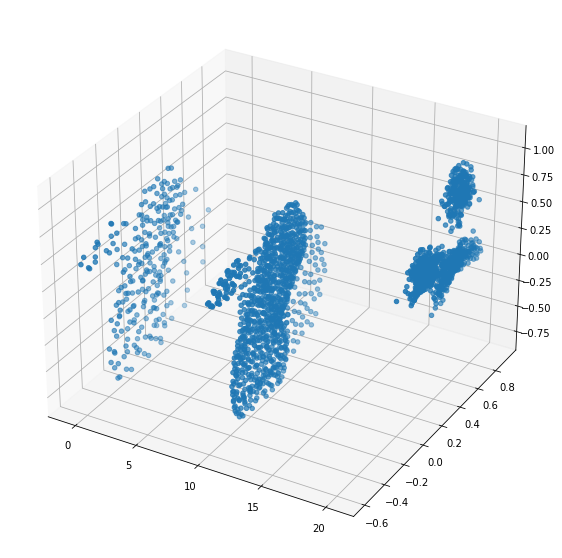

In [18]:
pred = pugcn(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

viz_many_mpl([data_cloud, gt_cloud, pred], d = 10, ax = ax)

In [19]:

def train(model, trainloader, loss_fn, optimizer):

    total_loss = 0.0
    for d in (t := tqdm(trainloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        # Train step
        optimizer.zero_grad()
        pred = model(p, batch=p_batch)
        
        pred, _ = to_dense_batch(pred, q_batch) # [B, N * r, 3]
        gt, _ = to_dense_batch(q, q_batch) # # [B, N * r, 3]
        d1, d2, _, _ = loss_fn(pred, gt)
        loss = d1.mean() + d2.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss / len(trainloader.dataset)


@torch.no_grad()
def evaluate(model, valloader, loss_fn):

    total_loss = 0.0
    for d in (t := tqdm(valloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        pred = model(p, batch=p_batch)
        
        pred = to_dense_batch(pred, q_batch)  # [B, N * r, 3]
        gt = to_dense_batch(q, q_batch)  # [B, N * r, 3]
        d1, d2, _, _ = loss_fn(pred, gt)
        loss = d1.mean() + d2.mean()

        total_loss += loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss / len(trainloader.dataset)


In [20]:
if "trained-models" not in os.listdir("."):
    os.mkdir("trained-models")
dir_name = datetime.now().strftime("%Y_%m_%d_%H_%M")
os.mkdir(os.path.join("trained-models", dir_name))
print(f"Saving checkpoints at {dir_name}")

Saving checkpoints at 2022_03_09_15_08


In [21]:
history = OmegaConf.create()
history.train_loss = []
history.val_loss = []
for epoch in tqdm(range(1, train_config.epochs + 1)):
    train_loss = train(pugcn, trainloader, loss_fn, optimizer)
    history.train_loss.append(train_loss)
    #val_loss = evaluate(pugcn, valloader, loss_fn)
    #history.val_loss.append(val_loss)
    
    print(f"{epoch=} \t {train_loss=:.6f}")
    
    if epoch == 1 or epoch % train_config.save_every == 0:
        torch.save(
            {
                "model_config": dict(model_config),
                "train_config": dict(train_config),
                "data_config": dict(data_config),
                "history": history,
                "epoch": epoch,
                "model_size": model_size(pugcn, unit = "KB"),
                "model_state_dict": pugcn.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            os.path.join("trained-models", dir_name, f"ckpt_epoch_{epoch}"),
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=1 	 train_loss=0.001970


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=2 	 train_loss=0.001121


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=3 	 train_loss=0.000790


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=4 	 train_loss=0.000674


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=5 	 train_loss=0.000712


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=6 	 train_loss=0.000713


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=7 	 train_loss=0.000709


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=8 	 train_loss=0.000696


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=9 	 train_loss=0.000686


  0%|          | 0/1725 [00:00<?, ?it/s]

epoch=10 	 train_loss=0.000676


In [ ]:
# Train 1 epoch 
#train_loss = train(pugcn, trainloader, loss_fn, optimizer)


In [29]:
idx = np.random.choice(len(dataset))
#dv = valset[idx]
dv = dataset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [30]:
pred = pugcn(sample.to(device)).cpu().detach().numpy()
pred

array([[ 0.1051702 ,  0.24156591, -0.26857504],
       [ 0.30744207,  0.21257195, -0.3004114 ],
       [ 0.1167144 ,  0.20376702, -0.2345563 ],
       ...,
       [ 0.24914132,  0.42248404,  0.5916215 ],
       [-0.03571557,  0.47196823,  0.71272147],
       [ 0.04465035,  0.49129707,  0.6520611 ]], dtype=float32)

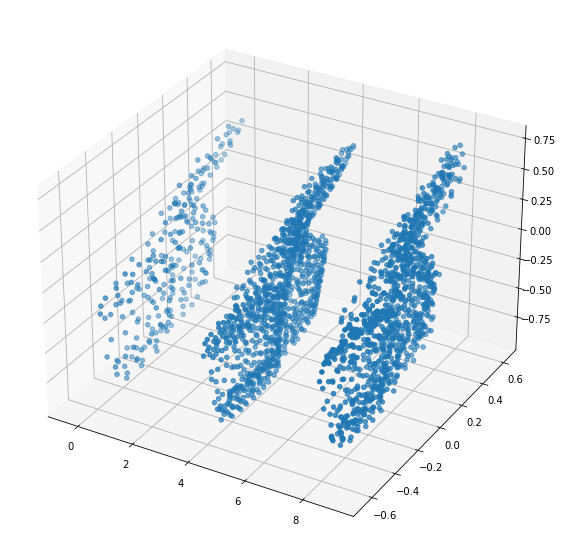

In [31]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([sample, gt, pred], d = 4, ax = ax)